# Suicide data analysis


In [1]:
import sqlalchemy as db
from matplotlib import pyplot as plt
from matplotlib import dates
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

#connect to db
engine = db.create_engine('postgresql://')#put db address here
connection = engine.connect()
metadata = db.MetaData()

yrsInDbase = 8

In [2]:
# #print database tables

#using MetaData
metadata.reflect(engine)
for table in metadata.tables.values():
    print("\n+++ "+table.name+" +++\n")
    columns = "| "
    for column in table.c:
        columns+=column.name+" | "
    print(columns)


+++ deathtype +++

| id | deathtype | 

+++ weather_all +++

| index | date_time | maxtempC | mintempC | totalSnow_cm | sunHour | uvIndex | uvIndex.1 | moon_illumination | moonrise | moonset | sunrise | sunset | DewPointC | FeelsLikeC | HeatIndexC | WindChillC | WindGustKmph | cloudcover | humidity | precipMM | pressure | tempC | visibility | winddirDegree | windspeedKmph | 

+++ mental_hospitals_busan +++

| index | year | num_hospitals | 

+++ alcohol_consumption_kr +++

| index | year | liters_pc | 

+++ inter_monetary_fund_kr +++

| index | year | unemployment_pcnt | gdp_pcnt_change | 

+++ population +++

| id | district | population | populationm | populationf | korpop | korpopm | korpopf | forpop | forpopm | forpopf | 

+++ job +++

| id | job | 

+++ marriage +++

| id | marriage | 

+++ suicidetable +++

| datentime | location | district | deathtype | gender | age | job | marriage | medhistory | uniqueness | addinfo | 

+++ spatial_ref_sys +++

| srid | auth_name | auth_srid 

In [3]:
#query data from suicidetable
suicidetable = db.Table('suicidetable', metadata, autoload=True, autoload_with=engine)
query = db.select([suicidetable])
resultProxy = connection.execute(query)
resultSet = resultProxy.fetchall()

### Suicide cases by year (linear regression)

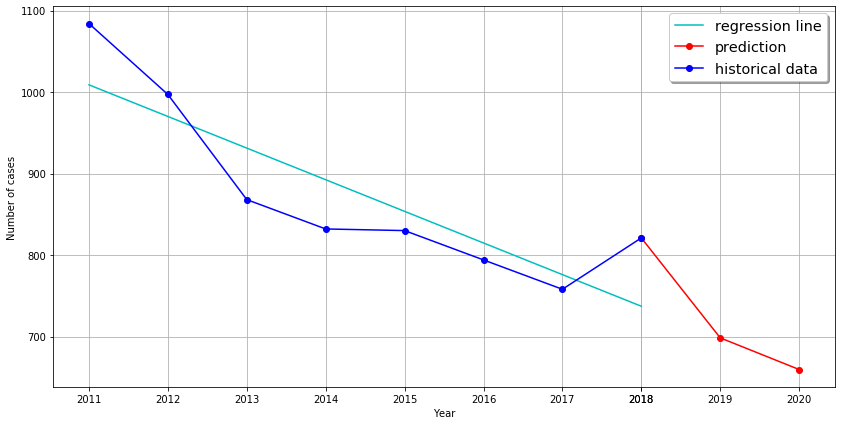

In [4]:
#get years
yrs = []
for entry in resultSet:
    yrs.append(entry[0].year)

yrs = np.sort(yrs)
xs = []
ys = []

#count
current = -1
for entry in yrs:
    if entry == current:
        ys[-1] += 1
    else:
        current = entry
        xs.append(entry)
        ys.append(1)

#linear regression
regression_model = LinearRegression()

year = []
for x in xs:
    year.append([x])
year = np.array(year)
cases = np.array(ys)

#create regression line
regression_model.fit(year, cases)
regressionLine = regression_model.predict(year)

#make predictions for next years
toPredict = [[2019], [2020]]
predictions = regression_model.predict(toPredict)
toPredict = np.insert(toPredict, 0, year[-1])
predictions = np.insert(predictions, 0, cases[-1])

fig, ax = plt.subplots(figsize=(14,7), facecolor='w')
ax.grid()
ax.set_xlabel("Year")
ax.set_ylabel("Number of cases")
ax.set_xticks(np.append(year , toPredict))
ax.plot(xs, regressionLine, "c-", label="regression line")
ax.plot(toPredict, predictions, "ro-", label="prediction")
ax.plot(xs,ys, "bo-", label="historical data")
ax.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.show()

### Suicide cases by year (2nd degree polynomial regression)

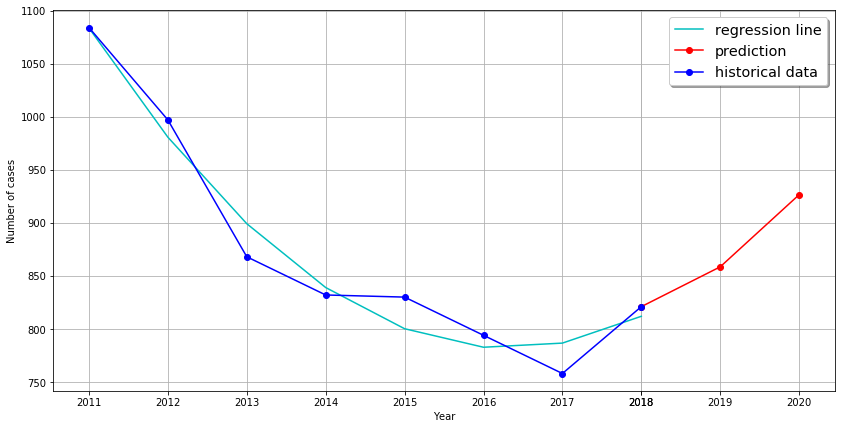

In [5]:
#polynomial regression
poly = PolynomialFeatures(degree=2)
yearTrans = poly.fit_transform(year)

regression_model.fit(yearTrans, cases)
regressionLine = regression_model.predict(yearTrans)

#make predictions for next years
toPredict = [[2019], [2020]]
toPredictTrans = poly.fit_transform(toPredict)

predictions = regression_model.predict(toPredictTrans)
toPredict = np.insert(toPredict, 0, year[-1])
predictions = np.insert(predictions, 0, cases[-1])

fig, ax = plt.subplots(figsize=(14,7), facecolor='w')
ax.grid()
ax.set_xlabel("Year")
ax.set_ylabel("Number of cases")
ax.set_xticks(np.append(year , toPredict))
ax.plot(xs, regressionLine, "c-", label="regression line")
ax.plot(toPredict, predictions, "ro-", label="prediction")
ax.plot(xs,ys, "bo-", label="historical data")
ax.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.show()

### Suicide cases by month (linear regression)

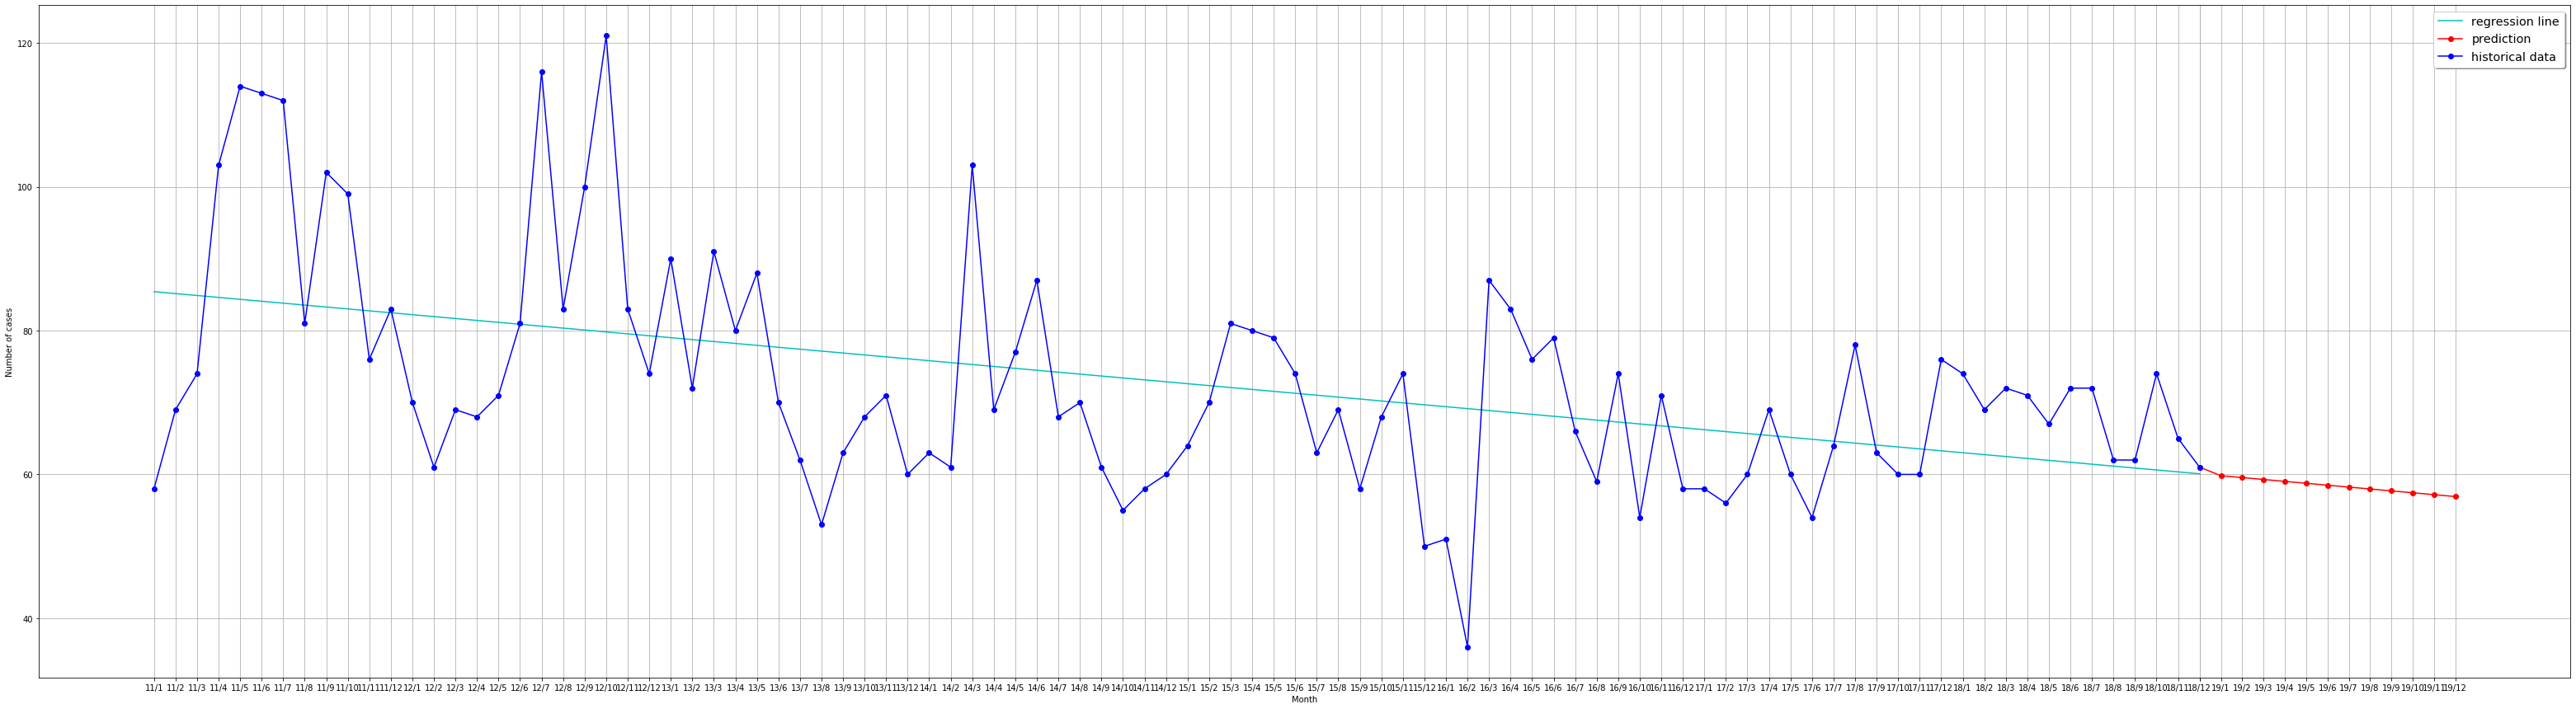

 & 61.0 & 59.8 & 59.6 & 59.3 & 59.0 & 58.8 & 58.5 & 58.2 & 58.0 & 57.7 & 57.4 & 57.2 & 56.9


In [66]:
#plot data by month
data = []
for r in resultSet:
    data.append(r[0])
data = np.sort(data)

xlabels = []
yvalues = []
year = -1
month = -1

for entry in data:
    if entry.month == month:
        yvalues[-1] += 1
    else:
        month = entry.month
        yvalues.append(1)
        xlabels.append(str(entry.year-2000)+"/"+str(month))

xs = np.linspace(0, len(xlabels), len(xlabels))

#visualise trendline (linear regression)
xaxis = []
for x in xs:
    xaxis.append([x])
xaxis = np.array(xaxis)
cases = np.array(yvalues)
regression_model.fit(xaxis, cases)
regressionLine = regression_model.predict(xaxis)

#make predictions for next year
toPredict = []
xlabels.append("")
for i in np.arange(1,13):
    toPredict.append([xs[-1]+i])
    xlabels.append("19/"+str(i))
    
#toPredict = toPredict.reshape(-1, 1)
predictions = regression_model.predict(toPredict)
toPredict = np.insert(toPredict, 0, xs[-1])
predictions = np.insert(predictions, 0, cases[-1])

fig, ax = plt.subplots(figsize=(55,15), facecolor='w')
ax.set_xticks(np.append(xs,toPredict))
ax.set_xticklabels(xlabels)
ax.set_xlabel("Month")
ax.set_ylabel("Number of cases")
ax.grid()
ax.plot(xs, regressionLine, "c-", label="regression line")
ax.plot(toPredict, predictions, "ro-", label="prediction")
ax.plot(xs, yvalues, "bo-", label="historical data")
ax.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.show()

printerino= ""
for i in predictions:
    printerino += " & " + '{0:.1f}'.format(i) 
print(printerino)

### Autoregressive moving average

In [65]:
# ARIMA example
from statsmodels.tsa.arima_model import ARIMA
from random import random
# contrived dataset
#data = [x + random() for x in range(1, 100)]
data = yvalues
# fit model
model = ARIMA(yvalues, order=(1, 1, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(yvalues), len(yvalues)+12, typ='levels')

printerino= ""
for i in yhat:
    printerino += " & " + '{0:.1f}'.format(i) 
print(printerino)
# fig, ax = plt.subplots(figsize=(55,15), facecolor='w')
# ax.set_xticks(np.append(xs,toPredict))
# ax.set_xticklabels(xlabels)
# ax.set_xlabel("Month")
# ax.set_ylabel("Number of cases")
# ax.grid()
# ax.plot(toPredict, yhat, "ro-", label="prediction")
# ax.plot(xs, yvalues, "bo-", label="historical data")
# ax.legend(loc='upper right', shadow=True, fontsize='x-large')
# plt.show()

 & 60.5 & 60.2 & 59.9 & 59.6 & 59.3 & 59.1 & 58.8 & 58.6 & 58.3 & 58.1 & 57.8 & 57.6 & 57.3


### Sarima

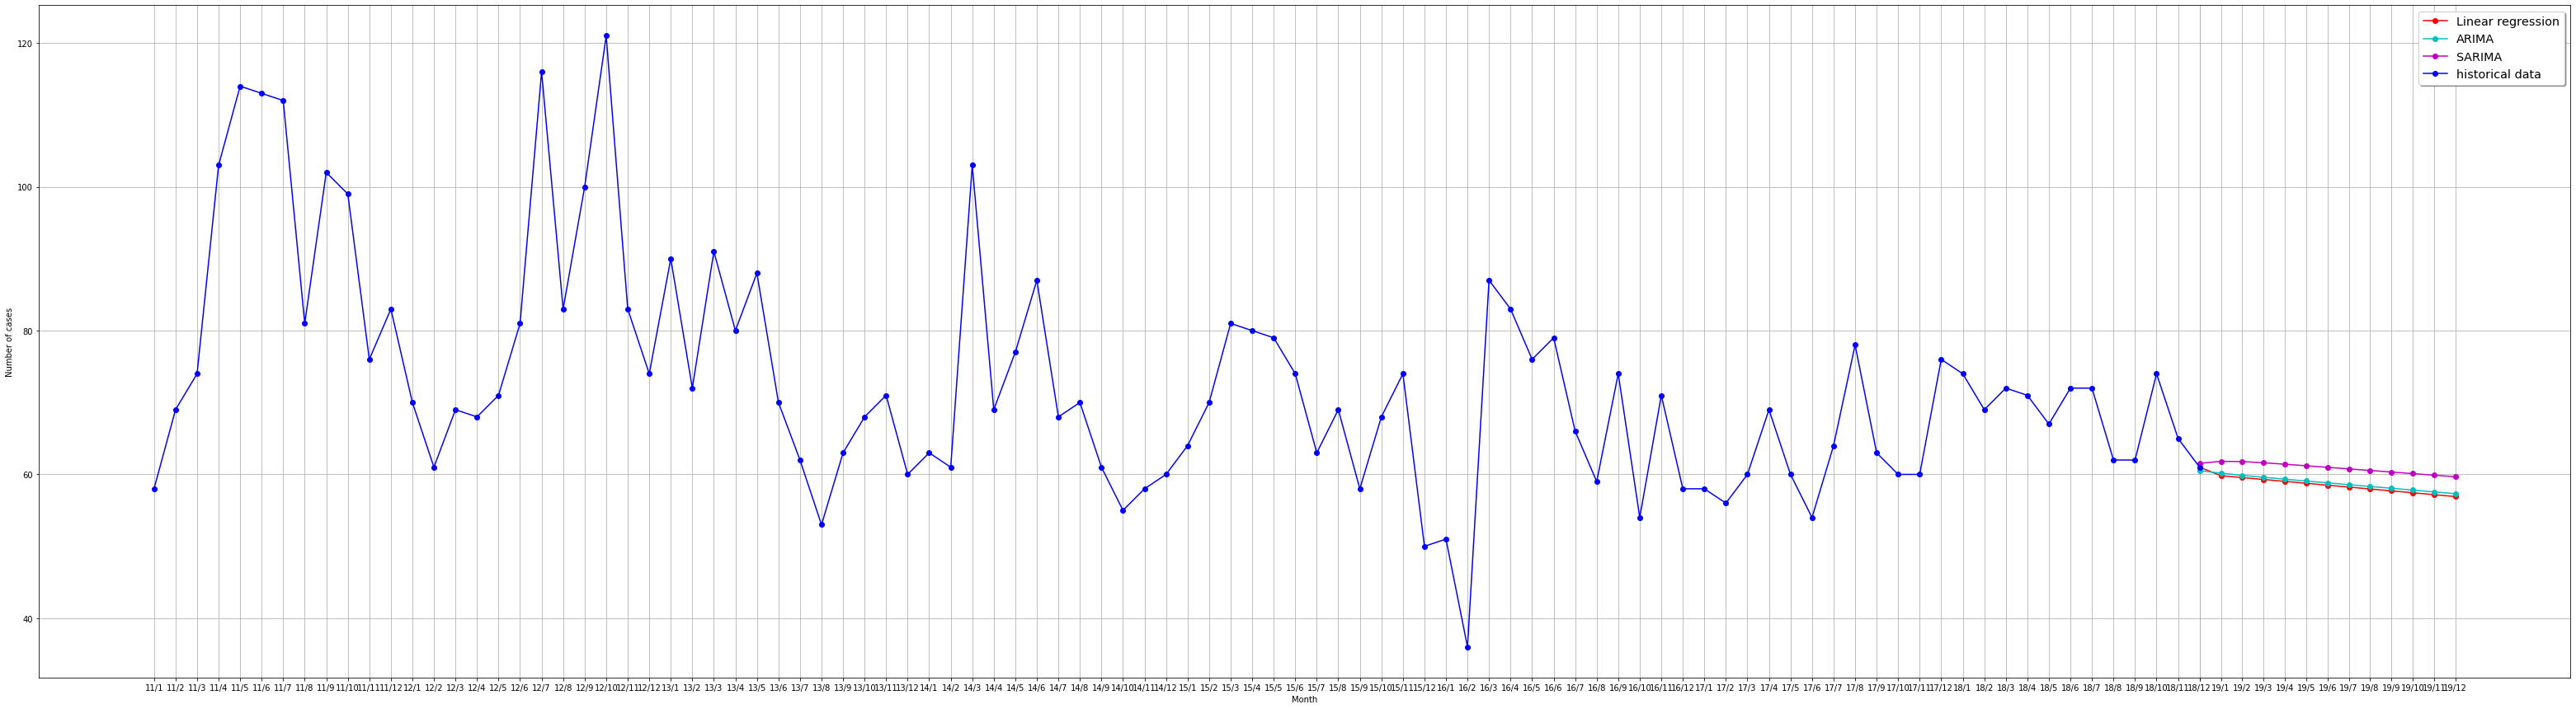

 & 61.5 & 61.8 & 61.8 & 61.6 & 61.4 & 61.2 & 61.0 & 60.8 & 60.5 & 60.3 & 60.1 & 59.9 & 59.7


In [69]:
# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random


#data = [x + random() for x in range(1, 100)]
data = yvalues
# fit model
model = SARIMAX(data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat2 = model_fit.predict(len(yvalues), len(yvalues)+12)

fig, ax = plt.subplots(figsize=(55,15), facecolor='w')
ax.set_xticks(np.append(xs,toPredict))
ax.set_xticklabels(xlabels)
ax.set_xlabel("Month")
ax.set_ylabel("Number of cases")
ax.grid()

ax.plot(toPredict, predictions, "ro-", label="Linear regression")
ax.plot(toPredict, yhat, "co-", label="ARIMA")
ax.plot(toPredict, yhat2, "mo-", label="SARIMA")
ax.plot(xs, yvalues, "bo-", label="historical data")
ax.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.show()

printerino= ""
for i in yhat2:
    printerino += " & " + '{0:.1f}'.format(i) 
print(printerino)

### Suicide cases by month (2nd degree polynomial regression)

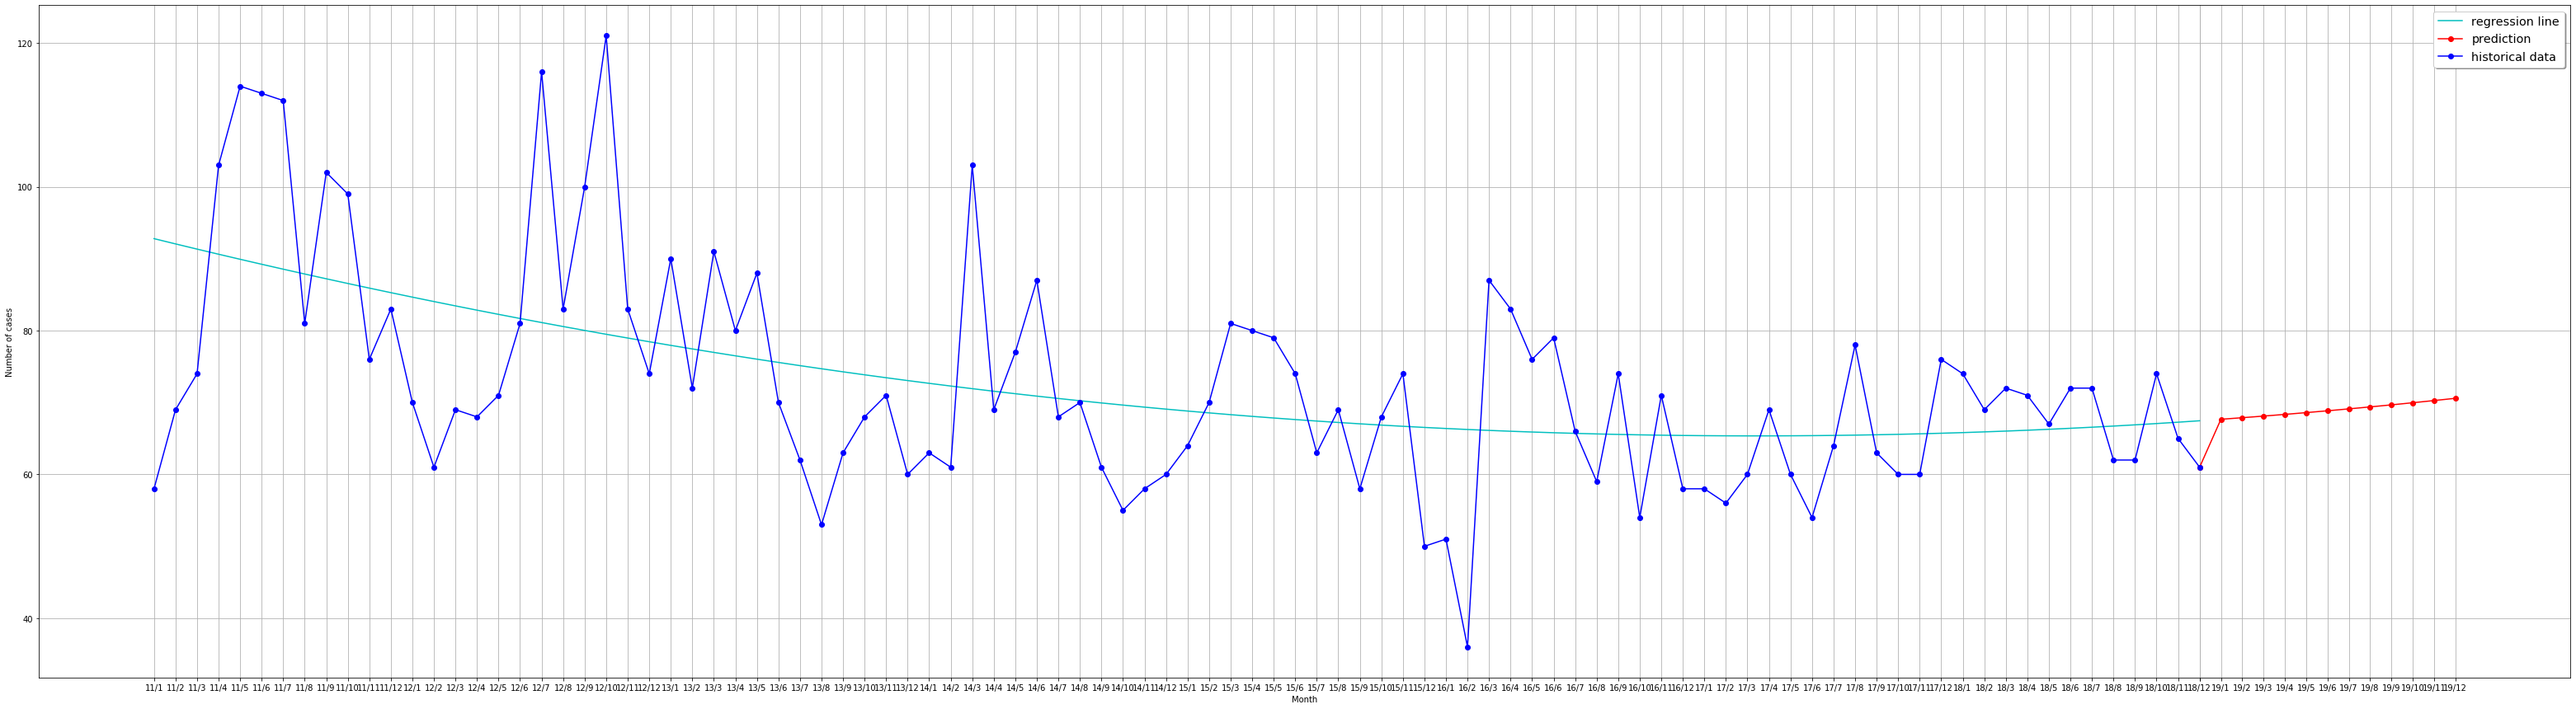

In [30]:
#polynomial regression
poly = PolynomialFeatures(degree=2)

xaxis = []
for x in xs:
    xaxis.append([x])
xaxis = np.array(xaxis)
cases = np.array(yvalues)

xTrans = poly.fit_transform(xaxis)
regression_model.fit(xTrans, cases)
regressionLine = regression_model.predict(xTrans)

#make predictions for next year
toPredict = []
xlabels.append("")
for i in np.arange(1,13):
    toPredict.append([xs[-1]+i])
    xlabels.append("19/"+str(i))
    
toPredictTrans = poly.fit_transform(toPredict)
    
#toPredict = toPredict.reshape(-1, 1)
predictions = regression_model.predict(toPredictTrans)
toPredict = np.insert(toPredict, 0, xs[-1])
predictions = np.insert(predictions, 0, cases[-1])

fig, ax = plt.subplots(figsize=(55,15), facecolor='w')
ax.set_xticks(np.append(xs,toPredict))
ax.set_xticklabels(xlabels)
ax.set_xlabel("Month")
ax.set_ylabel("Number of cases")
ax.grid()
ax.plot(xs, regressionLine, "c-", label="regression line")
ax.plot(toPredict, predictions, "ro-", label="prediction")
ax.plot(xs, yvalues, "bo-", label="historical data")
ax.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.show()

### Monthly suicides and KOSPI price (Korean cOmposite Stock Price Index)

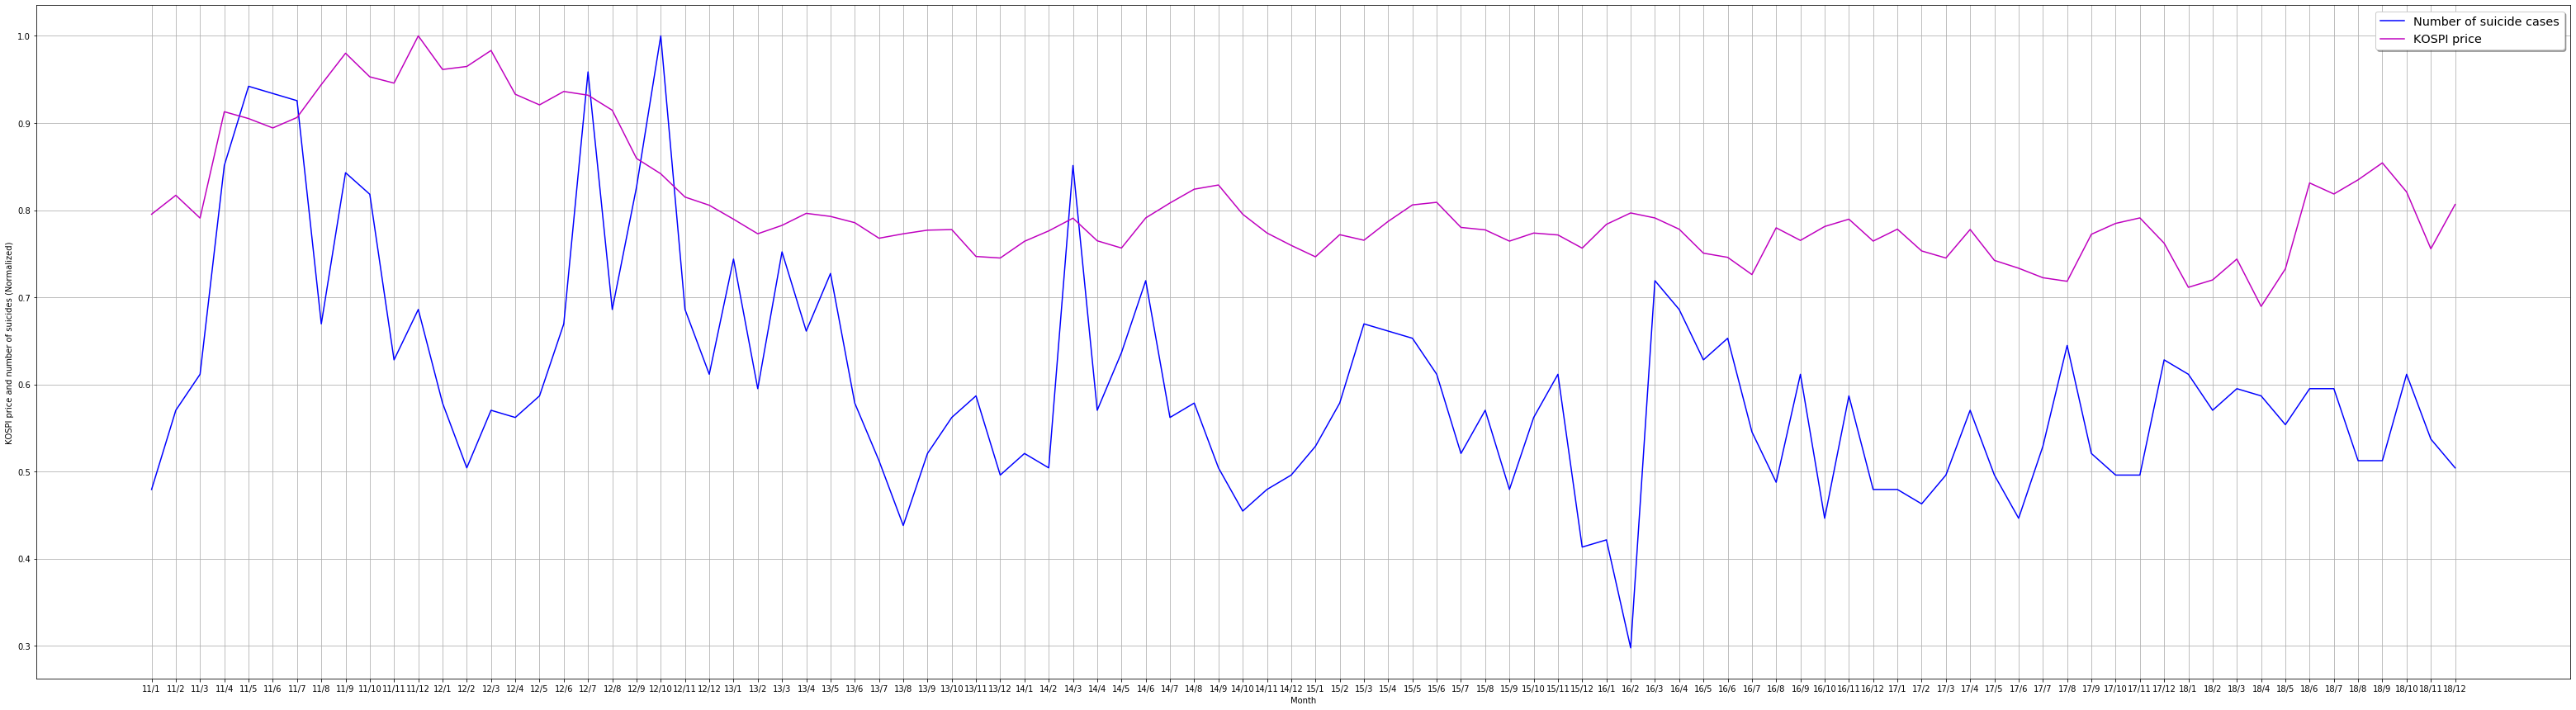

In [8]:
# ###
# # load KOSPI data in database
# ###
# import datetime
# import pandas as pd
# KOSPIdf = pd.read_csv("KOSPImonthly.csv")
# names = ['month', 'price', 'open', 'high', 'low', 'vol_billions', 'change']
# KOSPIdf.columns = names
# for i, d in enumerate(KOSPIdf['month']):
#     KOSPIdf['month'][i] = datetime.datetime.strptime(KOSPIdf['month'][i], '%b %y')
#     KOSPIdf['price'][i] =  float(KOSPIdf['price'][i].replace(',', ''))
#     KOSPIdf['open'][i] =  float(KOSPIdf['open'][i].replace(',', ''))
#     KOSPIdf['high'][i] =  float(KOSPIdf['high'][i].replace(',', ''))
#     KOSPIdf['low'][i] =  float(KOSPIdf['low'][i].replace(',', ''))
#     KOSPIdf['vol_billions'][i] =  float(KOSPIdf['vol_billions'][i].replace('B', ''))
#     KOSPIdf['change'][i] = float(KOSPIdf['change'][i].replace('%', ''))
# # KOSPIdf
# KOSPIdf.to_sql('kospi_data', con = engine)
# ###
# ### end load into db
# ###

# PLOT

KOSPItable = db.Table('kospi_data', metadata, autoload=True, autoload_with=engine)
query = db.select([KOSPItable])
resultProxy = connection.execute(query)
kospires = resultProxy.fetchall()

##plot data by month
kospivalues = []
for r in kospires:
    kospivalues.append(r['price'])
#normalize
kospivalues = [val/max(kospivalues) for val in kospivalues]
yvalues = [val/max(yvalues) for val in yvalues]
xs = np.linspace(0, len(kospivalues), len(kospivalues))

fig, ax = plt.subplots(figsize=(55,15), facecolor='w')
ax.set_xticklabels(xlabels)
ax.set_xticks(xs)
ax.set_xlabel("Month")
ax.grid()
ax.plot(xs, yvalues, "b-", label="Number of suicide cases")
ax.plot(xs, kospivalues, "m-", label="KOSPI price")
ax.legend(loc='upper right', shadow=True, fontsize='x-large')
ax.set_xlabel("Month")
ax.set_ylabel("KOSPI price and number of suicides (Normalized)")
plt.show()

### Average cases per month in a year

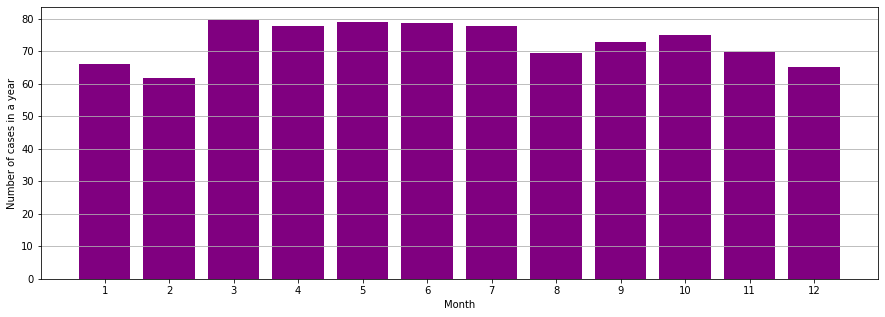

In [9]:
labels = [i for i in np.arange(1,13)]
monthCount = np.zeros(12)
#get months
for entry in resultSet:
    val = entry[0].month
    monthCount[val-1] += 1

monthCount /= 8.0
fig, ax = plt.subplots(figsize=(15,5), facecolor='w')
ax.grid(axis='y')
ax.set_xlabel("Month")
ax.set_ylabel("Number of cases in a year")
ax.set_xticks(labels)
ax.bar(labels, monthCount, width=0.8, align='center', color='purple')
plt.show()

### Yearly suicides by time of the day

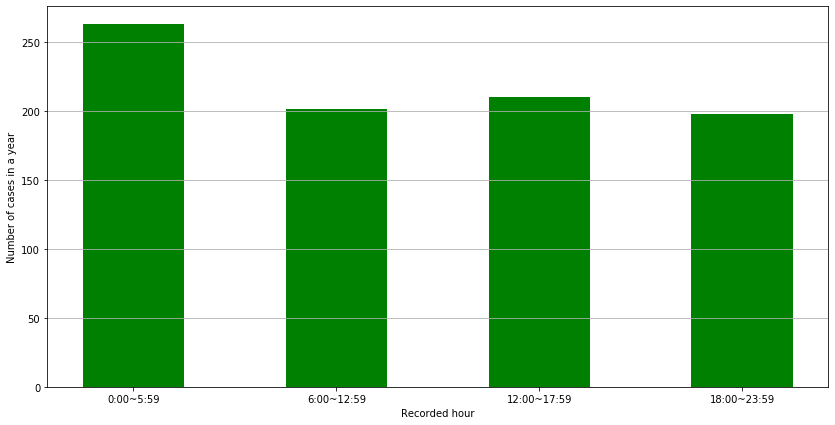

In [10]:
intervals = np.zeros(4)
for case in resultSet:
    h = case[0].hour
    if h < 6:
        intervals[0] += 1
    elif h < 12:
        intervals[1] += 1
    elif h < 18:
        intervals[2] += 1
    else:
        intervals[3] += 1

fig, ax = plt.subplots(figsize=(14,7), facecolor='w')
ax.grid(axis='y')
ax.bar(["0:00~5:59", "6:00~12:59", "12:00~17:59", "18:00~23:59"],
       intervals/yrsInDbase, color='green', width=0.5)
#barList[1].set_color('gold')
ax.set_ylabel("Number of cases in a year")
ax.set_xlabel("Recorded hour")
plt.show()

### Total suicide cases by district (2011~2018)

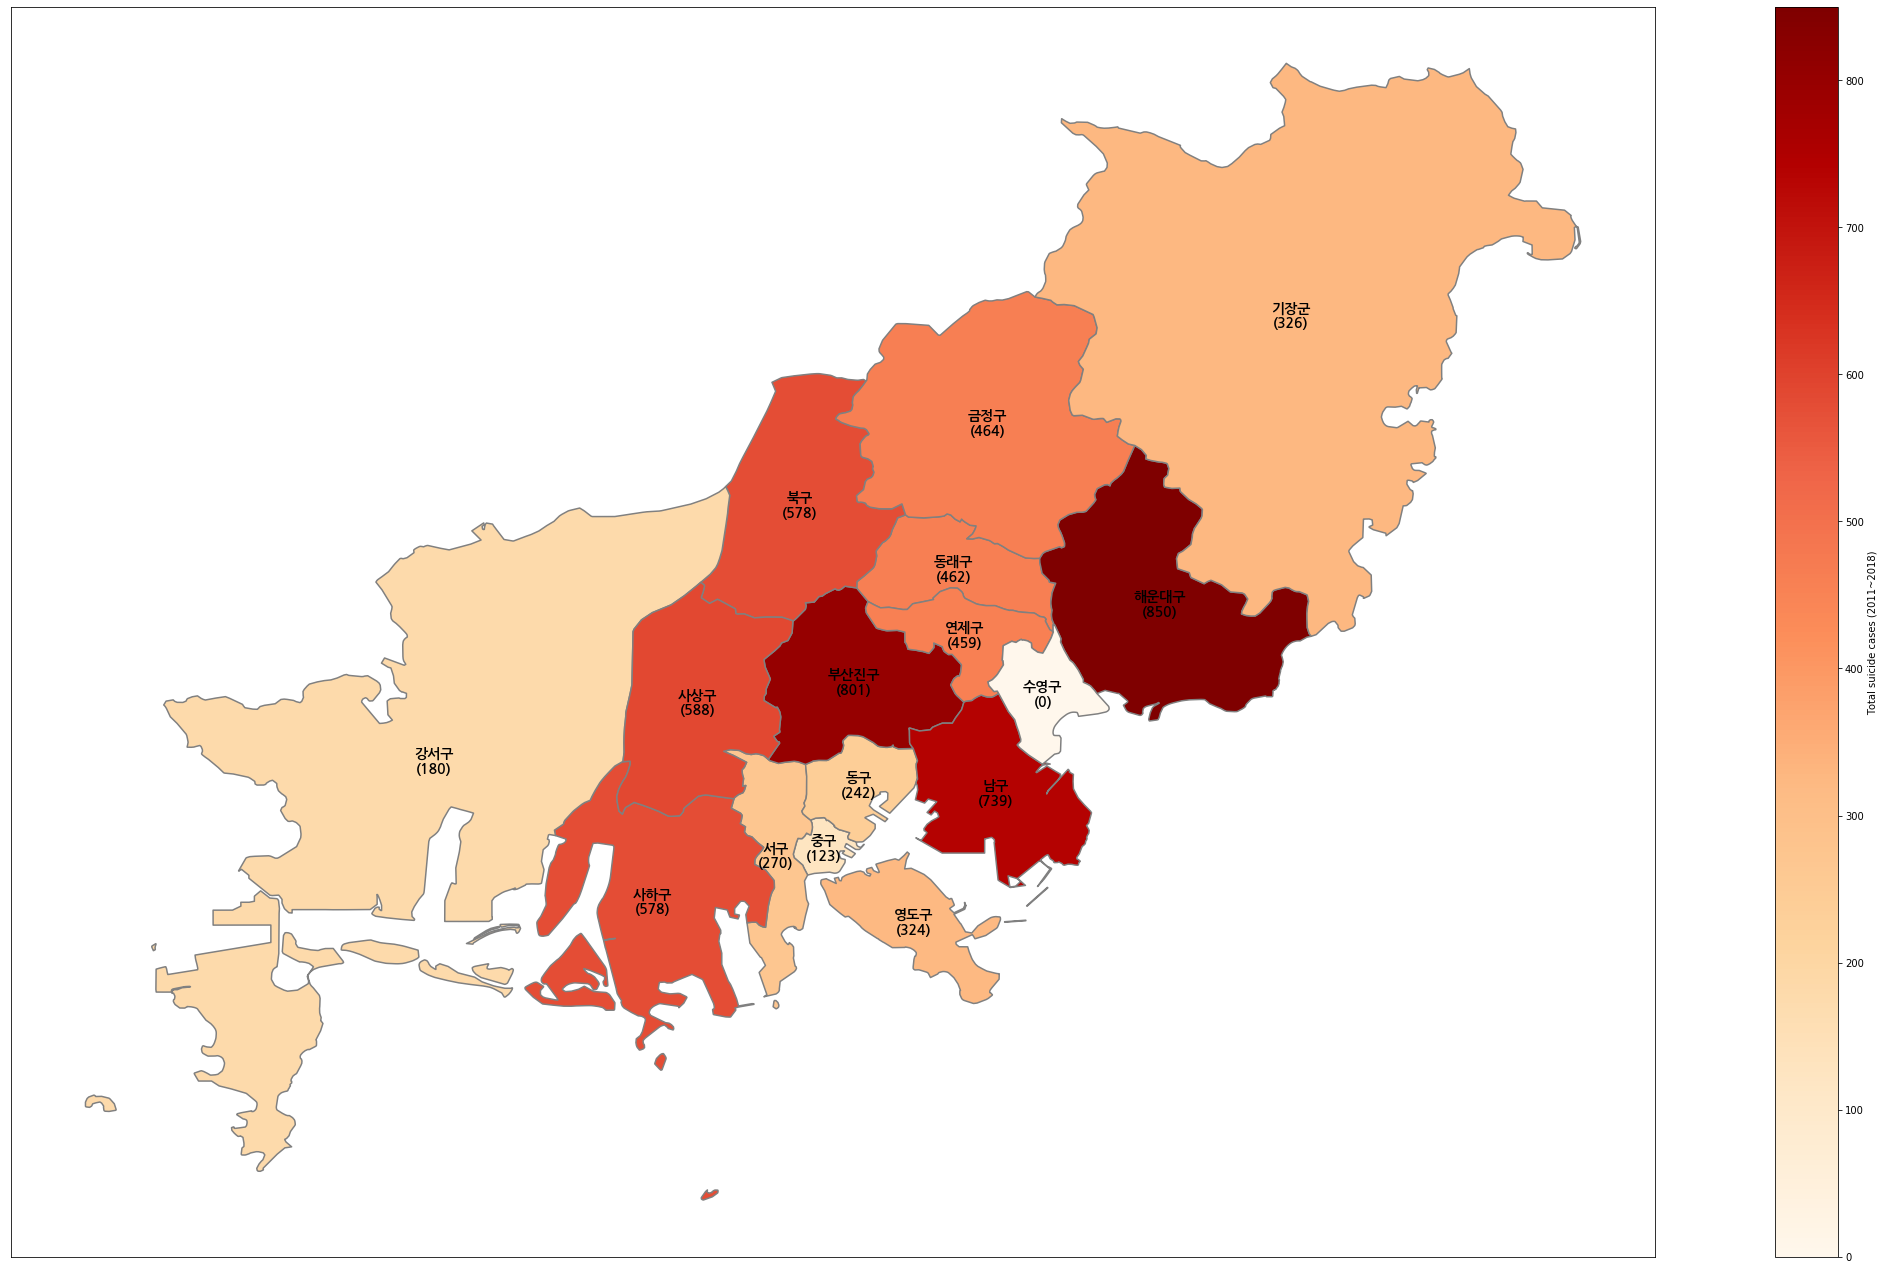

In [11]:
import geopandas as gpd
import pandas as pd

#한글 font
import matplotlib.font_manager as fm
# font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
# l = [(f.name, f.fname) for f in fm.fontManager.ttflist if 'Nanum' in f.name]
# print(l)
path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'
fontprop = fm.FontProperties(fname=path, size=18)

#read geojson data
df = gpd.read_file('BusanMunicipal.geojson')

# #query distrct data from db to compare the DB indices with the dataframe indices
# districtsT = db.Table('district', metadata, autoload=True, autoload_with=engine)
# query = db.select([districtsT])
# resultProxy = connection.execute(query)
# districtsFromDB = resultProxy.fetchall()
# print(df['name'])
# print("------")
# districtsFromDB

#count cases by district and add as column to the dataframe
distr = []
for entry in resultSet:
    distr.append(entry[2])

casesPerDistr = np.zeros(17)#ignore [0]
for v in distr:
    try:
        casesPerDistr[int(v)] += 1
    except:
        #print(v)
        pass#there's some(2) ??? values
    
# !!! there are 2 indices for haeundae, 8 and 16 !!!
# !!! assume 8 is suyeong for now !!!
# re-order this into an array with indices that match the dataframe's
# have to do it manually since names don't match between DB and dataframe
# db-index >changeto> dframe-index
# 1>0,2>5,3>3,4>2,5>4,6>1,7>6,8>8,9>14,10>10,11>9,12>12,13>11,14>7,15>15,(16>8)
cpd = np.zeros(16)
cpd[0] = casesPerDistr[1]
cpd[1] = casesPerDistr[6]
cpd[2] = casesPerDistr[4]
cpd[3] = casesPerDistr[3]
cpd[4] = casesPerDistr[5]
cpd[5] = casesPerDistr[2]
cpd[6] = casesPerDistr[7]
cpd[7] = casesPerDistr[14]
cpd[8] = casesPerDistr[8]
cpd[9] = casesPerDistr[11]
cpd[10] = casesPerDistr[10]
cpd[11] = casesPerDistr[13]
cpd[12] = casesPerDistr[12]
cpd[13] = 0#casesPerDistr[8]
cpd[14] = casesPerDistr[9]
cpd[15] = casesPerDistr[15]

#add to df
df['cases'] = cpd

#plot map
fig, ax = plt.subplots(figsize=(43, 23), facecolor='w')
ax.set_xticks([])
ax.set_yticks([])
ax = df.plot(ax = ax, column='cases', legend=True, cmap='OrRd', linewidth=1.5, edgecolor='grey',
             legend_kwds={'label': "Total suicide cases (2011~2018)"})

#add name annotations
centr = []
for idx, row in df.iterrows():
    coords = row['geometry']
    centr.append(coords.centroid)
    x = coords.centroid.x
    y = coords.centroid.y
    txt = row['name']+"\n("+str(int(row['cases']))+")"
    ax.annotate(txt, xy=(x,y),fontproperties=fontprop,
                weight='bold', ha='center', va='center', size=14, color='black')

centroids = np.array([[centr[indx].x,centr[indx].y] for indx,p in enumerate(centr)])
#ax.plot(centroids.T[0], centroids.T[1], 'ro')

plt.show()

### Yearly suicides per 100'000 people (normalized by district population)

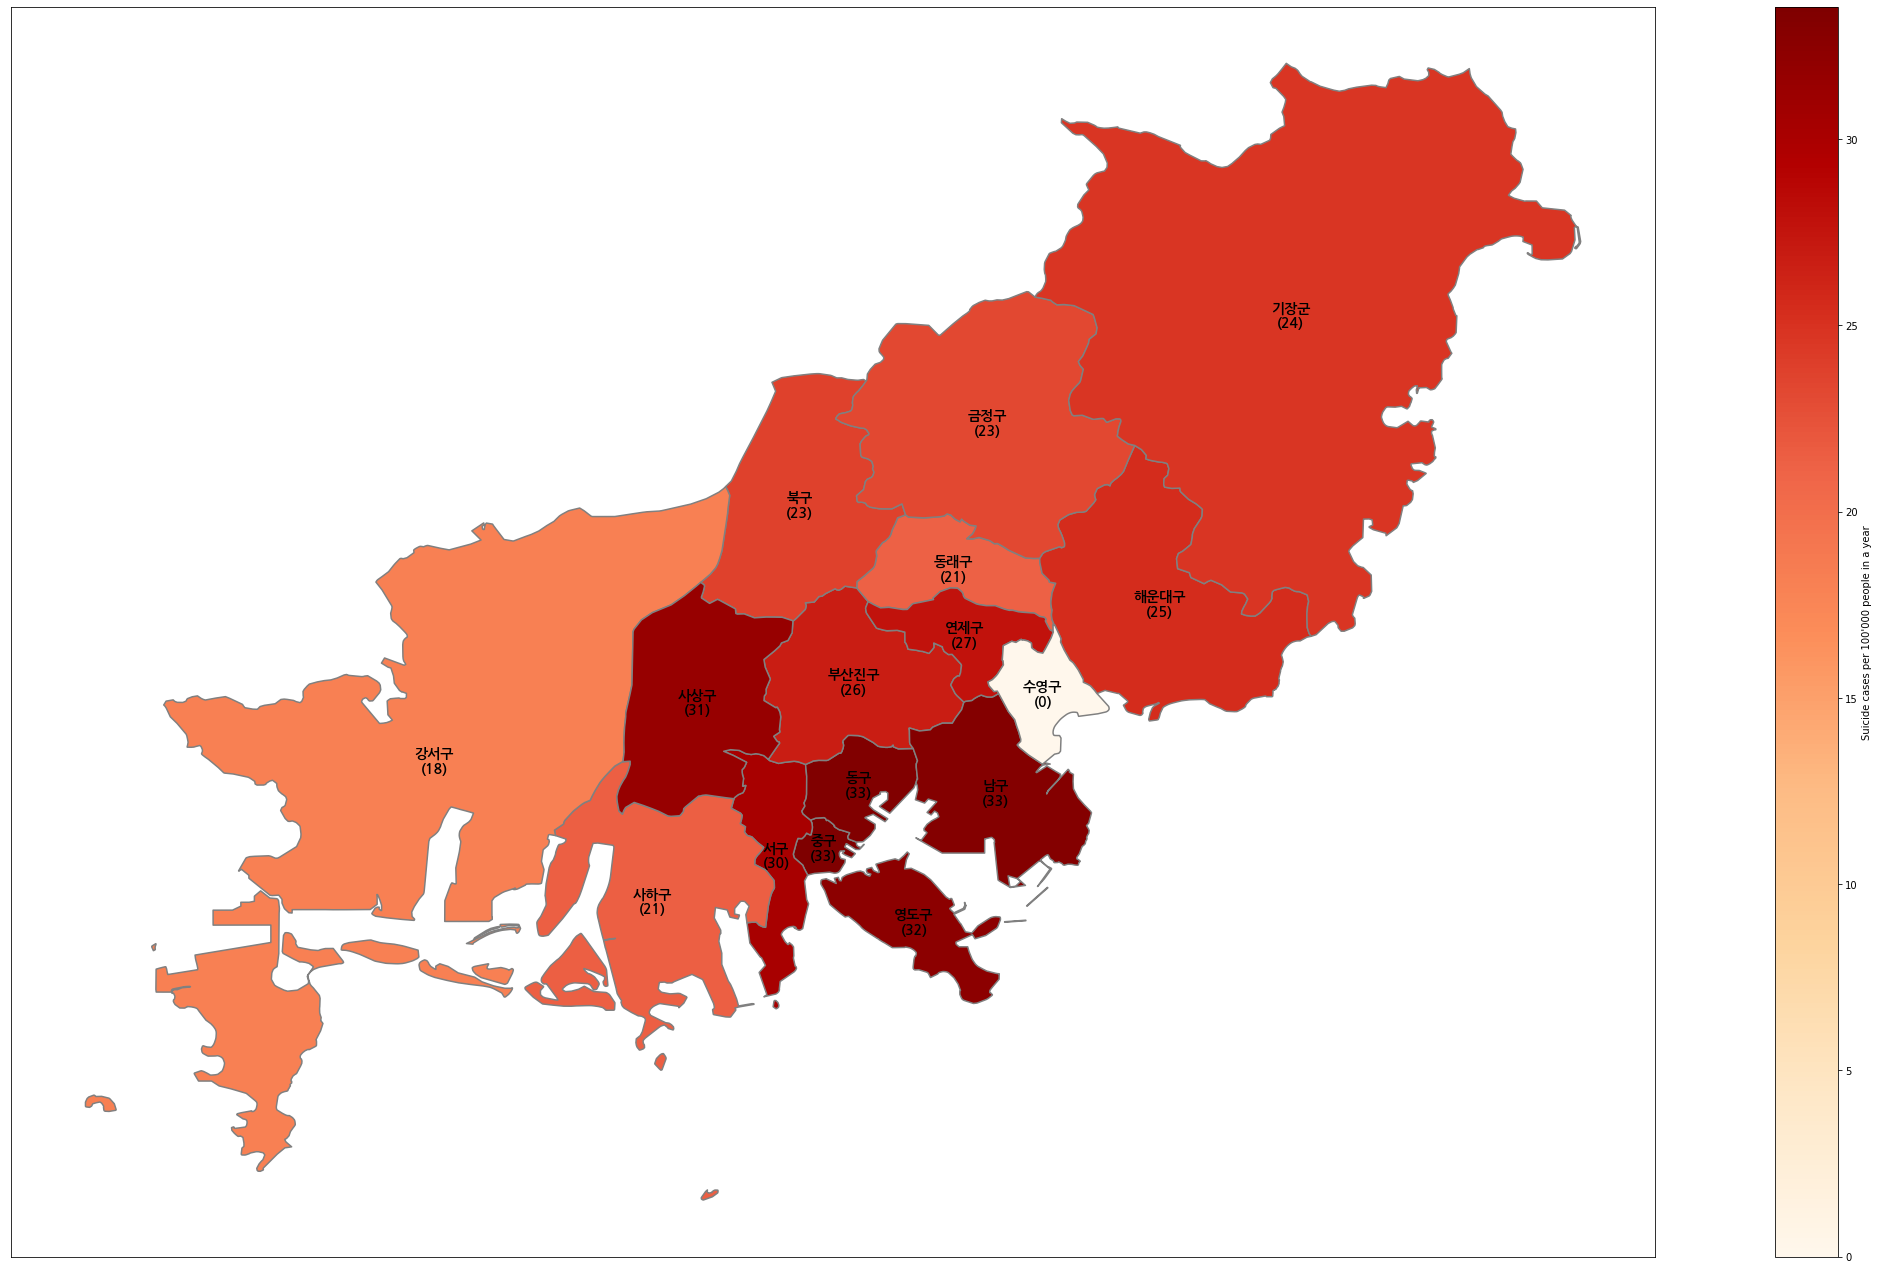

In [12]:
import geopandas as gpd
import pandas as pd

#read geojson data
df = gpd.read_file('BusanMunicipal.geojson')

# #query distrct data from db to compare the DB indices with the dataframe indices
# districtsT = db.Table('district', metadata, autoload=True, autoload_with=engine)
# query = db.select([districtsT])
# resultProxy = connection.execute(query)
# districtsFromDB = resultProxy.fetchall()
# print(df['name'])
# print("------")
# districtsFromDB

#count cases by district
distr = []
for entry in resultSet:
    distr.append(entry[2])

casesPerDistr = np.zeros(17)#ignore [0]
for v in distr:
    try:
        casesPerDistr[int(v)] += 1
    except:
        #print(v)
        pass#there's some(2) ??? values

# !!! there are 2 indices for haeundae, 8 and 16 !!!
# !!! assume 8 is suyeong for now !!!
# re-order this into an array with indices that match the dataframe's
# have to do it manually since names don't match between DB and dataframe
# db-index >changeto> dframe-index
# 1>0,2>5,3>3,4>2,5>4,6>1,7>6,8>8,9>14,10>10,11>9,12>12,13>11,14>7,15>15,(16>8)
cpd = np.zeros(16)
cpd[0] = casesPerDistr[1]
cpd[1] = casesPerDistr[6]
cpd[2] = casesPerDistr[4]
cpd[3] = casesPerDistr[3]
cpd[4] = casesPerDistr[5]
cpd[5] = casesPerDistr[2]
cpd[6] = casesPerDistr[7]
cpd[7] = casesPerDistr[14]
cpd[8] = casesPerDistr[8]
cpd[9] = casesPerDistr[11]
cpd[10] = casesPerDistr[10]
cpd[11] = casesPerDistr[13]
cpd[12] = casesPerDistr[12]
cpd[13] = 0#casesPerDistr[8]
cpd[14] = casesPerDistr[9]
cpd[15] = casesPerDistr[15]

# normalize by population
# https://en.wikipedia.org/wiki/Busan#Administrative_divisions
# index = df index
population = [45821.0, 111906.0, 90668.0, 124918.0, 372922.0, 271350.0, 278681.0,
              303955.0, 417174.0, 337423.0, 249054.0, 123636.0, 207396.0, 181526.0,
             233443.0, 164546.0]
for i, elem in enumerate(cpd):
    cpd[i]/=yrsInDbase
    cpd[i]/=population[i]
    cpd[i]*=100000.0#per 100000 people
    
#add as column to the dataframe
df['cases'] = cpd

#plot map
fig, ax = plt.subplots(figsize=(43, 23), facecolor='w')
ax.set_xticks([])
ax.set_yticks([])
ax = df.plot(ax = ax, column='cases', legend=True, cmap='OrRd', linewidth=1.5, edgecolor='grey',
             legend_kwds={'label': "Suicide cases per 100'000 people in a year"})

#add name annotations
centr = []
for idx, row in df.iterrows():
    coords = row['geometry']
    centr.append(coords.centroid)
    x = coords.centroid.x
    y = coords.centroid.y
    txt = row['name']+"\n("+str(int(row['cases']))+")"
    ax.annotate(txt, xy=(x,y),fontproperties=fontprop,
                weight='bold', ha='center', va='center', size=14, color='black')

centroids = np.array([[centr[indx].x,centr[indx].y] for indx,p in enumerate(centr)])
#ax.plot(centroids.T[0], centroids.T[1], 'ro')

plt.show()

## Suicides-weather graphs

In [13]:
temps =	{}
tempTotals = {}

# get weather data per each case
weather = db.Table('weather_all', metadata, autoload=True, autoload_with=engine)
for case in resultSet:
    day = case[0].strftime("%Y-%m-%d")
    query = db.select([weather.columns.maxtempC, weather.columns.mintempC]).where(weather.columns.date_time == day)
    tempTuple = connection.execute(query).fetchall()
    avgT = (tempTuple[0][0]+tempTuple[0][1])/2.0
    if(avgT in temps):
        temps[avgT] += 1
    else:
        temps[avgT] = 1

# count days per avg temp
query = db.select([weather.columns.maxtempC, weather.columns.mintempC])
tempTuples = connection.execute(query).fetchall()
for t in tempTuples:
    avgT = (t[0]+t[1])/2.0
    if(avgT in temps.keys()):
        if(avgT in tempTotals):
            tempTotals[avgT] += 1
        else:
            tempTotals[avgT] = 1

### Suicides-temperature graph 1 (Yearly number of cases by average day temperature)

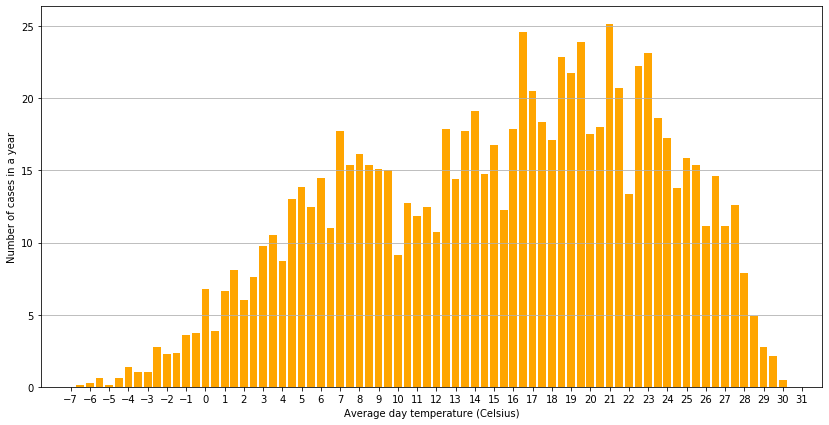

In [14]:
xs = []
ys = []
for temp, count in temps.items():
    xs.append(temp)
    ys.append(count/yrsInDbase)    
    
indxs = np.argsort(xs)
xs = np.sort(xs)
ys = [ys[i] for i in indxs]

fig, ax = plt.subplots(figsize=(14,7), facecolor='w')
ax.grid(axis='y')
ax.set_xticks([i for i in range(-7,32)])
ax.set_xlabel("Average day temperature (Celsius)")
ax.set_ylabel("Number of cases in a year")
ax.bar(xs,ys, color = 'orange', width=0.4)
plt.show()

### Suicides-temperature graph 2 (Weighted by n. of days in the year with each temperature)

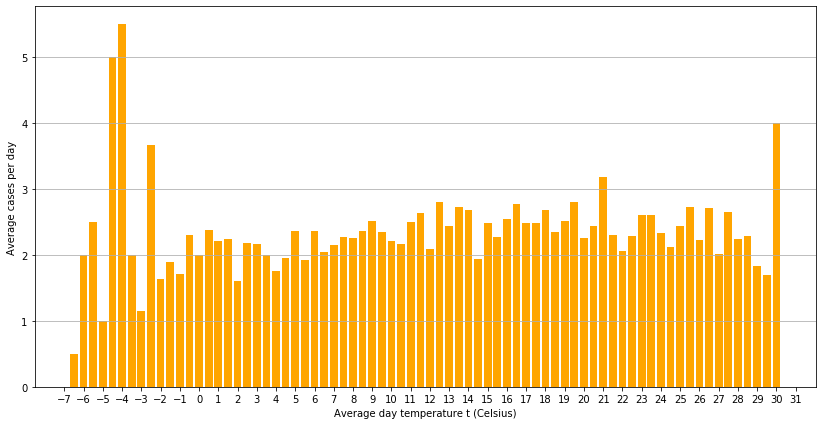

In [15]:
xs = []
ys = []
for temp, count in temps.items():
    count/=tempTotals[temp]
    xs.append(temp)
    ys.append(count)    
    
indxs = np.argsort(xs)
xs = np.sort(xs)
ys = [ys[i] for i in indxs]

#plot
fig, ax = plt.subplots(figsize=(14,7), facecolor='w')
ax.grid(axis='y')
ax.set_xticks([i for i in range(-7,32)])
ax.set_xlabel("Average day temperature t (Celsius)")
ax.set_ylabel("Average cases per day")
ax.bar(xs,ys, color='orange', width=0.4)
plt.show()

### Suicides-temperature graph 3 (Weighted by n. of days in the year with each temperature, average by range)

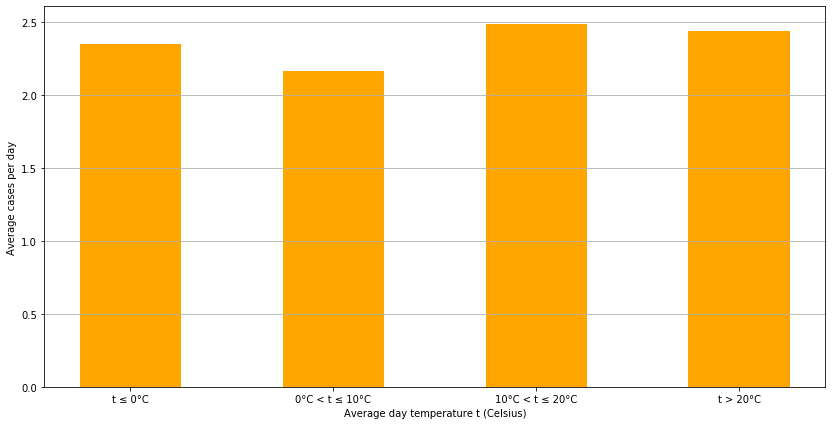

In [16]:
lims = [0, 10, 20]
xs = [f"t ≤ {lims[0]}°C",
      f"{lims[0]}°C < t ≤ {lims[1]}°C",
      f"{lims[1]}°C < t ≤ {lims[2]}°C",
      f"t > {lims[2]}°C"]
ys = np.zeros(len(lims)+1)
ycount = np.zeros(len(lims)+1)
#counts
for temp, count in temps.items():
    p = 0
    if (temp > lims[0]) and (temp <= lims[1]):
      p = 1
    if (temp > lims[1]) and (temp <= lims[2]):
      p = 2
    elif temp > lims[2]:
      p = 3    
    count /= tempTotals[temp]
    ys[p] += count
    ycount[p] += 1.0

#group average
ys = [ ys[i]/ycount[i] for i in range(len(ycount))]

fig, ax = plt.subplots(figsize=(14,7), facecolor='w')
ax.grid(axis='y')
ax.set_xlabel("Average day temperature t (Celsius)")
ax.set_ylabel("Average cases per day")
ax.bar(xs,ys, color = 'orange', width=0.5)
plt.show()

### Suicides-rain graph 1 (Yearly number of cases with rain and no rain)

In [17]:
rainy = 0
notRainy = 0
for case in resultSet:
    day = case[0].strftime("%Y-%m-%d")
    query = db.select([weather.columns.precipMM]).where(weather.columns.date_time == day)
    mm = connection.execute(query).fetchall()
    #if it rained
    if mm[0][0] > 0.0:
        rainy += 1
    else:
        notRainy += 1

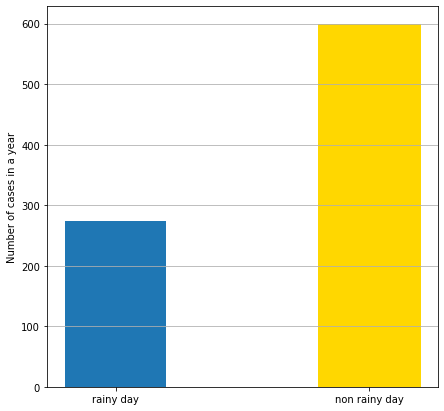

In [18]:
fig, ax = plt.subplots(figsize=(7,7), facecolor='w')
ax.grid(axis='y')
barList = ax.bar(["rainy day","non rainy day"],[rainy/yrsInDbase,notRainy/yrsInDbase],width=0.4)
barList[1].set_color('gold')
ax.set_ylabel("Number of cases in a year")
plt.show()

### Suicides-rain graph 2 (Suicides when rain/no rain, weighted by days in a year with rain/no rain)

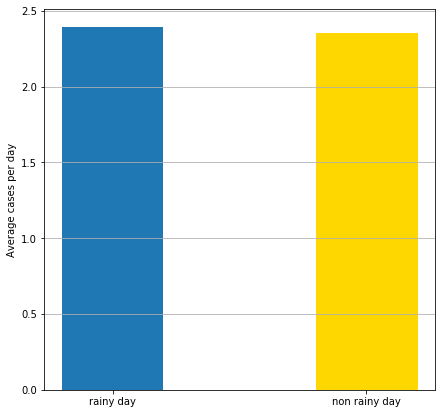

In [19]:
totRain = 0
totNoRain = 0
query = db.select([weather.columns.precipMM])
rainRes = connection.execute(query).fetchall()

for mm in rainRes:
    if mm[0] > 0:
        totRain += 1
    else:
        totNoRain += 1

b1 = rainy/totRain
b2 = notRainy/totNoRain

fig, ax = plt.subplots(figsize=(7,7), facecolor='w')
labels = [i.get_text() for i in ax.get_yticklabels()]
ax.grid(axis='y')
barList = ax.bar(["rainy day", "non rainy day"], [b1, b2],width=0.4)
barList[1].set_color('gold')
ax.set_ylabel("Average cases per day")
plt.show()

### Suicides-Sun hours graph 1 (Yearly number of cases per total hours of sunlight in the day)

In [20]:
shrs = {}
shYearTot = {}

# get weather data per each case
for case in resultSet:
    day = case[0].strftime("%Y-%m-%d")
    query = db.select([weather.columns.sunHour]).where(weather.columns.date_time == day)
    sunHours = connection.execute(query).fetchall()
    if(sunHours[0][0] in shrs):
        shrs[sunHours[0][0]] += 1
    else:
        shrs[sunHours[0][0]] = 1

# count days per avg temp
query = db.select([weather.columns.sunHour])
sunHours = connection.execute(query).fetchall()
for sh in sunHours:
    if(sh[0] in shrs.keys()):
        if(sh[0] in shYearTot):
            shYearTot[sh[0]] += 1
        else:
            shYearTot[sh[0]] = 1

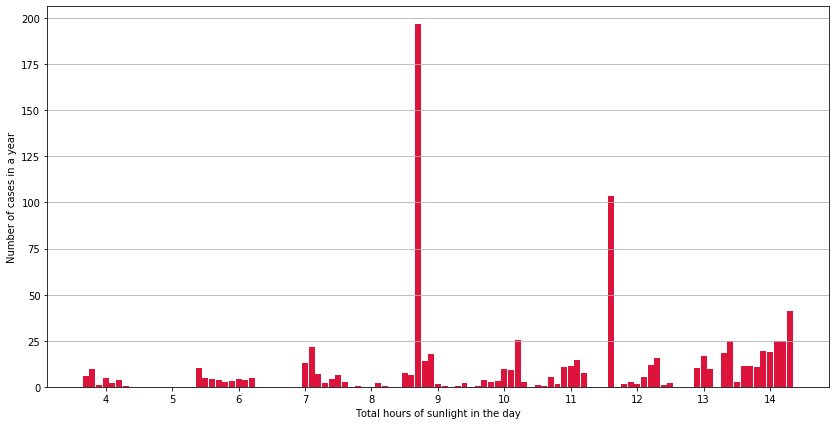

In [21]:
xs = []
ys = []
for indx, count in shrs.items():
    xs.append(indx)
    ys.append(count/yrsInDbase)    
    
indxs = np.argsort(xs)
xs = np.sort(xs)
ys = [ys[i] for i in indxs]

fig, ax = plt.subplots(figsize=(14,7), facecolor='w')
ax.grid(axis='y')
ax.set_xticks([i for i in range(0,15)])
ax.set_xlabel("Total hours of sunlight in the day")
ax.set_ylabel("Number of cases in a year")
ax.bar(xs,ys, color = 'crimson', width = 0.09)
plt.show()

### Suicides-Sun hours graph 2 (Weighted by n. of days in the year with each total hours of sunlight)

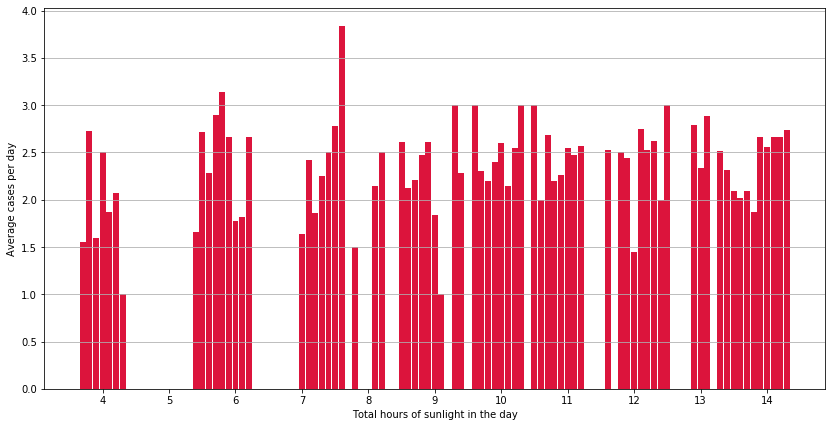

In [22]:
xs = []
ys = []
for indx, count in shrs.items():
    count/=shYearTot[indx]
    xs.append(indx)
    ys.append(count)
    
indxs = np.argsort(xs)
xs = np.sort(xs)
ys = [ys[i] for i in indxs]

#plot
fig, ax = plt.subplots(figsize=(14,7), facecolor='w')
ax.grid(axis='y')
ax.set_xticks([i for i in range(0,15)])
ax.set_xlabel("Total hours of sunlight in the day")
ax.set_ylabel("Average cases per day")
ax.bar(xs,ys, color='crimson', width=0.09)
plt.show()